In [1]:
import sys
sys.path.append('../../')
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from scipy.ndimage import laplace
from modules.generate_data.simulate_system import simulate
from modules.loaders.format_data import format_data_general
%matplotlib ipympl

In [2]:
# Parameters
L = 10                # Size of the grid
N = 50               # Number of grid points
T = 200               # Length of simulation
dt = 0.001            # Time step
nits = int(T / dt)    # Number of time steps
Du = 0.01             # Diffusion coefficient for u
Dv = 1                # Diffusion coefficient for v
a = 1
b = 1
k = 0.01

def reaction(u, v, a, b, k):
    F = (a * u**2 * v) / (1 + k * u**2) - b * u
    return F

# Reaction-diffusion update function
def update(u0, v0, a, b, k, Du, Dv, dt, ksqu, ksqv):

    F = reaction(u0, v0, a, b, k)
    
    u1r = u0 + F * dt
    v1r = v0 - F * dt
    
    u1r_hat = np.fft.fft2(u1r)
    v1r_hat = np.fft.fft2(v1r)
    
    u1 = np.real(np.fft.ifft2(u1r_hat / (1 - dt * ksqu)))
    v1 = np.real(np.fft.ifft2(v1r_hat / (1 - dt * ksqv)))

    return u1, v1  

def delete_after_ss(array):
    # Remove zeros from arrays due to reaching steady state
    mask = np.array([not np.all(np.diagonal(array[i]) == 0) for i in range(array.shape[0])])
    filtered_array = array[mask]
    
    return filtered_array
  

In [3]:
kx = (2*np.pi/L) * 1j * np.hstack((np.arange(0, N//2), np.array([0]), np.arange(-N//2+1, 0)))
ky = kx.copy()

k2x = kx**2
k2y = ky**2

kxx, kyy = np.meshgrid(k2x, k2y)

ksqu = Du * (kxx + kyy)
ksqv = Dv * (kxx + kyy)

In [4]:
u0 = 1
v0 = 1.0246

u = (np.random.rand(N, N) + 0.5) * u0
v = (np.ones((N, N))) * v0

In [5]:
rows = int(nits / 500) + 1
u_array = np.zeros((rows, N, N))
v_array = np.zeros((rows, N, N))
t_array = np.zeros(rows)

# Time-stepping loop
for t in range(nits):
    if t % 500 == 0:
        u_array[int(t/500), :, :] = u
        v_array[int(t/500), :, :] = v
        t_array[int(t / 500)] = t * dt
                  
        if t > 0 and np.max(np.abs(u_array[int(t/500), :, :] - u_array[int(t/500)-1, :, :])) < 0.1:
            print(f'Steady state at t = {t * dt}')
            break
           
    u, v = update(u, v, a, b, k, Du, Dv, dt, ksqu, ksqv)

u_array = delete_after_ss(u_array)
v_array = delete_after_ss(v_array)
t_array = np.trim_zeros(t_array, 'b')    


Steady state at t = 60.5


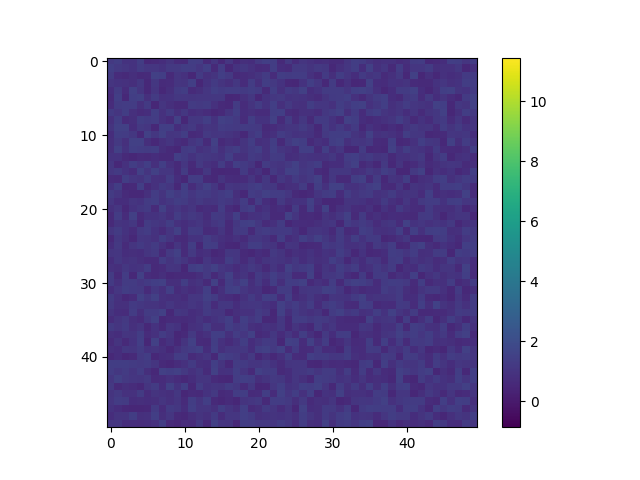

In [6]:
# Create list of included frame numbers
frames = range(0, len(u_array))

# Define function to update data
def animate(i):
    u_plot.set_array(u_array[i, :, :])
    ax.set_title(f'T = {i * dt * 500}')
    return [u_plot]

# Plot animation
fig, ax = plt.subplots()
u_plot = ax.imshow(u_array[0, :, :], cmap='viridis')
u_plot.set_clim(vmin=u_array[:, :, :].min(), vmax=u_array[:, :, :].max())
cbar = plt.colorbar(u_plot, ax=ax)

anim = animation.FuncAnimation(fig, animate, frames=frames, repeat=True, interval=200)
plt.show()
#writergif = animation.PillowWriter(fps=20)
#anim.save(f'test.gif', writer=writergif)